In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
import nclcmaps as nclc
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date, subtract_days_from_date

In [2]:
# Set up paths
server= 'great'
if server == 'great':
    path_to_data = '/home/nash/DATA/data/'
else:
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only

path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
arname = 'jan1989'
# import configuration file for case study choice
yaml_doc = '../data/config_files/ar_casestudy.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ar_dict = config[arname]

year = ar_dict['year']
month = ar_dict['month']
start_date = ar_dict['start_date']
end_date = add_days_to_date(ar_dict['end_date'], 1)
print(start_date, end_date)

# Select lat/lon grid
lonmin = 60.2
lonmax = 100
latmin = 16
latmax = 50

1989-01-03 1989-01-07


In [4]:
fname = path_to_data + 'CH2_generated_data/Global_Landslide_Catalog_Export.csv' #TODO check this - is it the raw downloaded data?
landslide = pd.read_csv(fname)

# Select lat/lon grid
lonmin = 65
lonmax = 100
latmin = 20
latmax = 42

## Select Landslides within Southern Asia region
idx = (landslide.latitude >= latmin) & (landslide.latitude <= latmax) & (landslide.longitude >= lonmin) & (landslide.longitude <= lonmax)
landslide = landslide.loc[idx]
# set event time as index
landslide = landslide.set_index(pd.to_datetime(landslide.event_date))
# landslide.index = landslide.index.normalize()

# rename and reindex
landslide = landslide.rename(columns={"latitude": "lat", "longitude": "lon", "event_date": "event_time"})
landslide = landslide.reset_index()

# round event time to the nearest 6 hours
landslide['time'] = landslide['event_date'].dt.round('6H')
landslide = landslide.set_index(pd.to_datetime(landslide.time))

# select only landslide dates that are between december and may
idx = (landslide.index.month >= 12) | (landslide.index.month <= 2)
landslide = landslide[idx]

idx = (landslide.index >= start_date) & (landslide.index <= end_date)
landslide = landslide[idx]
landslide

,event_date,source_name,source_link,event_id,event_time,event_time,event_title,event_description,location_description,location_accuracy,...,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,lon,lat,time
time,,,,,,,,,,,,,,,,,,,,,


In [5]:
landslide_lats = landslide['lat'].values
landslide_lons = landslide['lon'].values

In [6]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)


### WRF Terrain

In [7]:
wrf_filenames = ar_dict['wrf_files2'] 
wrfin = nc.Dataset(wrf_filenames[0])
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height


## Import WRF data

In [8]:
### get freezing level anomalies
# clim_mean = xr.open_dataset(path_to_data + 'wrf_hasia/d01/zerodegisotherm/filtered_daily_mean_clim_zerodegisotherm.nc')
clim_mean = xr.open_dataset('/home/sbarc/students/nash/data/wrf_hasia/d01/zerodegisotherm_ar_clim_new.nc')
clim_mean = clim_mean.sel(AR_CAT = 1)

clim_std = xr.open_dataset('/home/sbarc/students/nash/data/wrf_hasia/d01/zerodegisotherm_ar_std_new.nc')
clim_std = clim_std.sel(AR_CAT = 1)
clim_mean

<xarray.Dataset>
Dimensions:  (lat: 249, lon: 259)
Coordinates:
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    AR_CAT   int64 1
Data variables:
    z        (lat, lon) float32 ...

In [9]:
%%time
domains = ['d01', 'd01', 'd02', 'd01']
varname_lst = ['ivt', 'geopotential', 'prec', 'zerodegisotherm']
res_lst = ['3hr', '3hr', '3hr', '3hr']


## loop through each ds
ds_lst = []
for i, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):
    if server == 'great':
        data_path = path_to_data + 'wrf_hasia/'
    else:
        data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'
        
    if res == 'daily':
        filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
    else: 
        filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)
    
    fname = data_path + filename_pattern
    print(fname)
    ds = xr.open_dataset(fname)
    
    # subset to just ar days
    ds = ds.sel(time = slice(start_date, end_date))
    
    if varname == 'ivt':
        ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
    if varname == 'geopotential':
        ds = ds.sel(lev=250.)
    if varname == 'prec':
        # Calculate precipitation rate
        ds = ds.shift(time=-1) - ds # if in xarray
    # if varname == 'zerodegisotherm':
    #     ## Calculate Anomalies for zero degree isotherm
    #     ds = ds.groupby('time.dayofyear') - clim_mean
        
    # select the 00 UTC, 06 UTC, 18 UTC hour
    idx = (ds.time.dt.hour == 0) | (ds.time.dt.hour == 6) | (ds.time.dt.hour == 12) | (ds.time.dt.hour == 18)
    ds = ds.sel(time=idx)
    
    ds_lst.append(ds)
    
# ds_lst[0]

/home/nash/DATA/data/wrf_hasia/d01/ivt/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d01/geopotential/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_1989.nc
CPU times: user 376 ms, sys: 458 ms, total: 835 ms
Wall time: 2.92 s


In [10]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# extent of maps
ext = [lonmin,lonmax,latmin,latmax]
ext2 = [69.0, 89.0, 28.0, 43.]
ext2 = [71, 79, 32, 37] # Western precip anomalies

# Set tick/grid locations for d01
dx = np.arange(round(ext[0], 0),round(ext[1]+10, 0),10)
dy = np.arange(round(ext[2], 0),round(ext[3]+10, 0),10)

# Set tick/grid locations for d02
dx2 = np.arange(round(ext2[0], 0),round(ext2[1]+4, 0),4)
dy2 = np.arange(round(ext2[2], 0),round(ext2[3]+4, 0),4)

# get correct grid size for figure
nplots = len(ds_lst[0].time)
print(nplots)
if nplots > 40:
    ncols = 6
elif (nplots <= 40) & (nplots > 28):
    ncols = 5
elif (nplots <= 28) & (nplots > 18):
    ncols = 4
elif (nplots <= 18):
    ncols = 3
else:
    ncols = 4
    
print('nplots:', nplots, 'ncols:', ncols)
rem = nplots % ncols # check for remainder
nrows = nplots // ncols # integer division

# hack for tick labels to only label far right and bottom grids
share_bottom = [False]*(ncols)*(nrows-1) + [True]*ncols
share_right = ([False]*(ncols-1) + [True])*nrows

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
letter_lst = letter_lst + letter_lst

20
nplots: 20 ncols: 4


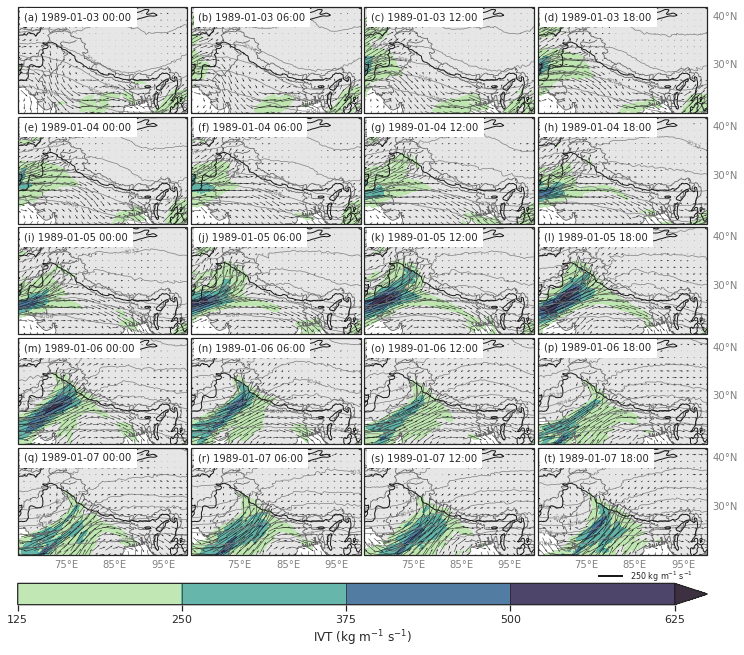

In [11]:
filepath = path_to_figs + arname + '_WRF_IVT_3hr.png'

# Create figure
fig = plt.figure(figsize=(16, (2*nrows)+1))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

if rem > 0:
    axgr = axgr[:-(rem)]
    # hide extra grids if uneven number of time steps
    for i in range(rem):
        axgr[-(i+1)].remove()
else:
    axgr = axgr

for k, ax in enumerate(axgr):    
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k])
        
    # IVT (filled contour)
    data = ds_lst[0]
    uvec = data.ivtu.isel(time=k).values
    vvec = data.ivtv.isel(time=k).values
    ivt = data.ivt.isel(time=k).values
    ivt_sm = gaussian_filter(ivt, sigma=1.5)
    cflevs = np.arange(125, 650, 125)
    cf = ax.contourf(data.lon.values, data.lat.values, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmo.deep, alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(data.lon.values, data.lat.values, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # 250-hPa Heights (contour lines)
    data = ds_lst[1]
    hgts = data.z.isel(time=k).values/10. #convert to decimeters
    clevs = np.arange(840, 1280, 12)
    cs = ax.contour(data.lon.values, data.lat.values, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7, linestyles='solid')
    kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 10, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # Contour Lines (terrain)
    terclevs=np.array([1000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    # subtitles
    date = data.time[k].values
    t = pd.to_datetime(str(date)) 
    timestring = t.strftime('%Y-%m-%d %H:00')
    ttl = "({0}) ".format(letter_lst[k]) + timestring
    ax.text(0.04, 0.9525, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)

# quiver key
qk = ax.quiverkey(Q, 0.5, -0.2, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


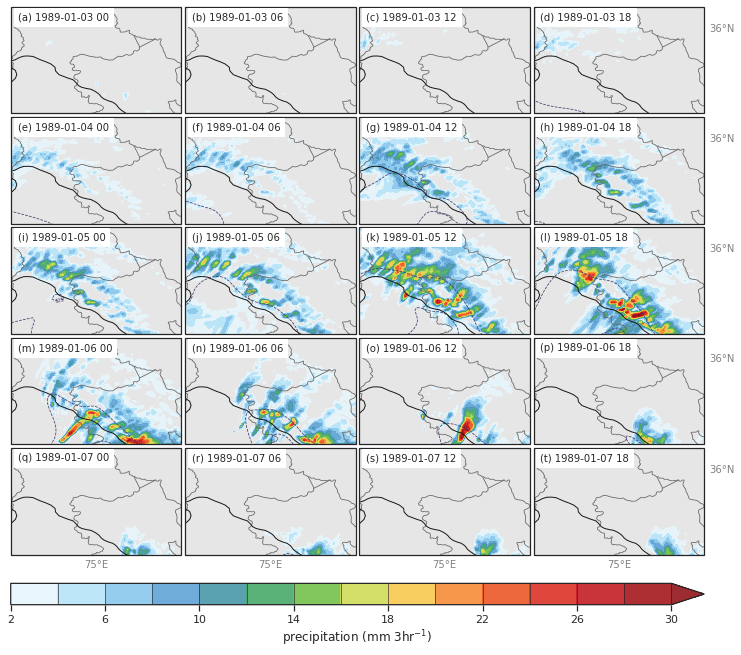

In [12]:
filepath = path_to_figs + arname + '_WRF_prec_3hr.png'

# Create figure
fig = plt.figure(figsize=(20, (2*nrows)+1))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

if rem > 0:
    axgr = axgr[:-(rem)]
    # hide extra grids if uneven number of time steps
    for i in range(rem):
        axgr[-(i+1)].remove()
else:
    axgr = axgr

for k, ax in enumerate(axgr):  
    ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=False, right_lats=share_right[k], 
                      bottom_lons=share_bottom[k], mask_ocean=False)
    
    
    # Contour Filled (prec)
    data = ds_lst[2] 
    prec = data.prec.isel(time=k).values
    cflevs = np.arange(2, 32, 2)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(data.lon.values, data.lat.values, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # Contour Lines (IVT)
    data = ds_lst[0]
    ivt = data.ivt.isel(time=k).values
    ivt_sm = gaussian_filter(ivt, sigma=2.0)
    ivtclevs=np.array([125, 250, 375, 500])
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cl = ax.contour(data.lon.values, data.lat.values, ivt_sm, ivtclevs, colors='#3f396c', linewidths=0.75,
                    linestyles='dashed', transform=datacrs)
    plt.clabel(cl, **kw_clabels)
    
    # Contour Lines (terrain)
    terclevs=np.array([1000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # subtitles
    date = ds.time[k].values
    t = pd.to_datetime(str(date)) 
    timestring = t.strftime('%Y-%m-%d %H')
    ttl = "({0}) ".format(letter_lst[k]) + timestring
    ax.text(0.04, 0.9525, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('precipitation (mm 3hr$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


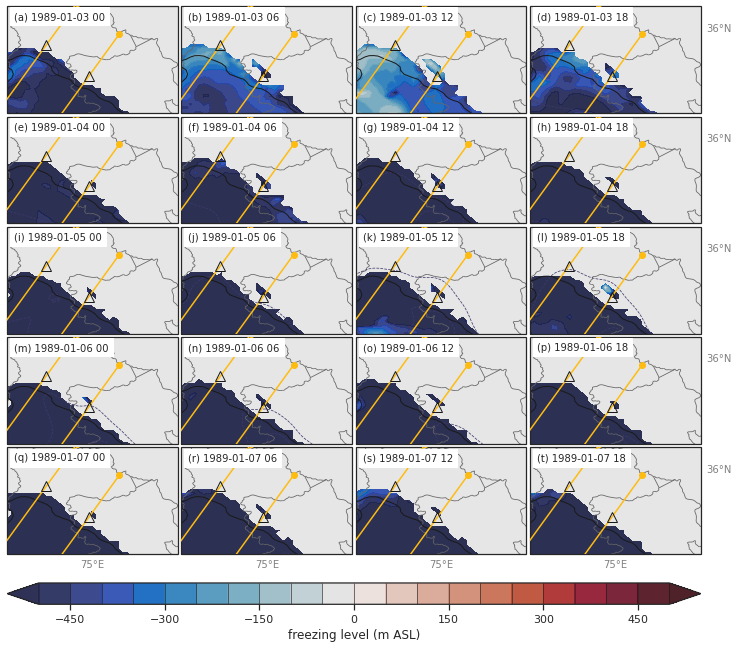

In [13]:
filepath = path_to_figs + arname + '_WRF_freezing-level_3hr.png'
# Create figure
fig = plt.figure(figsize=(20, (2*nrows)+1))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

if rem > 0:
    axgr = axgr[:-(rem)]
    # hide extra grids if uneven number of time steps
    for i in range(rem):
        axgr[-(i+1)].remove()
else:
    axgr = axgr

for k, ax in enumerate(axgr):  
    ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=False, right_lats=share_right[k], 
                      bottom_lons=share_bottom[k], mask_ocean=False)
    
    
    # freezing level (filled contour)
    data = ds_lst[3]
    z = data.z.isel(time=k).values - clim_mean.z.values
    cflevs = np.arange(-500, 550, 50)
    cf = ax.contourf(data.lon.values, data.lat.values, z, transform=datacrs,
                     levels=cflevs, cmap=cmo.balance, alpha=0.9, extend='both')

    # Contour Lines (IVT)
    data = ds_lst[0]
    ivt = data.ivt.isel(time=k).values
    ivt_sm = gaussian_filter(ivt, sigma=2.0)
    ivtclevs=np.array([125, 250, 375, 500])
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cl = ax.contour(data.lon.values, data.lat.values, ivt_sm, ivtclevs, colors='#3f396c', linewidths=0.75,
                    linestyles='dashed', transform=datacrs)
    plt.clabel(cl, **kw_clabels)
    
    # Contour Lines (terrain)
    terclevs=np.array([1000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # add meridional lines
    for i, line in enumerate(newline):
        ax.plot([line[1], line[3]],
                    [line[0], line[2]], color='#FEBC11', marker="o",
                    transform=datacrs, zorder=3)
        
        
    # add intersection points
    for i, pt in enumerate(ptlst):
        ax.plot(pt[0], pt[1], marker='^', ms=10, mec='k', mfc="None", transform=mapcrs, zorder=101)
        
    if len(landslide_lats) > 0:
        # add landslide points
        for i, (xs, ys) in enumerate(zip(landslide_lons, landslide_lats)):
            ax.plot(xs, ys, alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
    
    # subtitles
    date = ds.time[k].values
    t = pd.to_datetime(str(date)) 
    timestring = t.strftime('%Y-%m-%d %H')
    ttl = "({0}) ".format(letter_lst[k]) + timestring
    ax.text(0.04, 0.9525, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('freezing level (m ASL)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [ ]:
## points of landslides (chosen in fig10_wvf_climatology-analysis.ipynb)
pt1 = [72.6625, 34.8733]
pt2 = [74.0225, 34.0876]

ptlst = [pt1, pt2]

# hlat, hlon, tlat, tlon
Line1 = [pt1[1], pt1[0], pt2[1], pt2[0]] # this line is a line between the 2 landslide points
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate perpindicular line to line between landslide points at x for pt1 and pt2
newx_lst = [pt1[0], pt2[0]]
newline = []
x3_lst = [70.5, 72.]
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx, x3=x3_lst[i])
    newline.append(line)


In [ ]:
## points of landslides (chosen in fig10_wvf_climatology-analysis.ipynb)
pt1 = [72.6625, 34.8733]
pt2 = [74.0225, 34.0876]
# Line1 = [latmin, lonmin, latmax, lonmax] 

line1 = [32., pt1[0], 35., pt1[0]]
line2 = [32., pt2[0], 35., pt2[0]]

newline = [line1, line2]

In [ ]:
if arname == 'jan2002':
    test_date = '2002-01-12 18:00'
    title='January 2002'
elif arname == 'feb2010':
    test_date = '2010-02-08 12:00'
    title='February 2010'
elif arname == 'feb2011':
    test_date = '2011-02-13 00:00'

filepath = path_to_figs + arname + '_WRF_prec_event.png'

# Create figure
fig = plt.figure(figsize=(5, 5))

nrows=1
ncols=1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):  
    ax = draw_basemap(ax, extent=[68.25, 82.0, 30.0, 40.3], xticks=dx2, yticks=dy2, left_lats=False, right_lats=True, 
                      bottom_lons=True, mask_ocean=False)
    
    
    # Contour Filled (prec)
    data = ds_lst[2].sum('time')
    prec = data.prec.values
    print(prec.min(), prec.max())
    cflevs = np.arange(2, 212, 10)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(data.lon.values, data.lat.values, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
#     # Contour Lines (IVT)
#     data = ds_lst[0].sel(time=test_date)
#     ivt = data.ivt.values
#     ivt_sm = gaussian_filter(ivt, sigma=2.0)
#     ivtclevs=np.array([125, 250, 375, 500])
#     cl = ax.contour(data.lon.values, data.lat.values, ivt_sm, ivtclevs, colors='#3f396c', linewidths=0.75,
#                     linestyles='dashed', transform=datacrs)
#     plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)
    
    # Contour Lines (terrain)
    terclevs=np.array([3000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # # add zonal lines
    # line_lst = [Line2, Line3]
    # color_lst = ['yellow', 'cyan', 'magenta']
    # for i, line in enumerate(line_lst):
    #     ax.plot([line[1], line[3]],
    #                 [line[0], line[2]], color='#EF5645', marker="o",
    #                 transform=datacrs, zorder=3)
        
    # add meridional lines
    for i, line in enumerate(newline):
        ax.plot([line[1], line[3]],
                    [line[0], line[2]], color='#FEBC11', marker="o",
                    transform=datacrs, zorder=3)
        
        
    # add intersection points
    for i, pt in enumerate(ptlst):
        ax.plot(pt[0], pt[1], marker='^', ms=10, mec='k', mfc="None", transform=mapcrs, zorder=101)
    
    # if arname == 'feb2010':
    #     # add landslide points
    #     landslide_pts = [[73.7526, 34.0049], [75.8011, 33.1595], [72.6625, 34.8733]]
    #     for i, pt in enumerate(landslide_pts):
    #         ax.plot(pt[0], pt[1], alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
        
    # subtitles
    ax.set_title(title, loc='left',fontsize=13)

    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('precipitation (mm event$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [ ]:
newline